## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link. 

**Update:** This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains many additional slides and masks you can use. Note that while the starter code below downloads one slide from a Google Cloud URL (we have hosted this online for you for convenience), you will need to find a way to work with the other slides yourself for practice. You do not need to use them all! Just a few. You can either host the slides you'll use on Cloud storage using any provider, or you can download from Google Drive in your notebook (this may be slow).

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

# Import libraries

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (268 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import pathlib
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras

from patchify import patchify
import cv2
import matplotlib.ticker as plticker
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    # (x, y) tuple giving the top left pixel in the level 0 reference frame
    im = im.convert('RGB') # drop the alpha channel (alpha indicates how opaque each pixel is)
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image) # convert an RGB image into grayscale. pixel values changed from (0,255) to (0,1)
    # Gray level images use a single value per pixel that is called intensity or brightness. 0 is black, 255 is white.
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity) # Return the indices of the elements that are non-zero or True.
    return list(zip(indices[0], indices[1]))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels" % len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


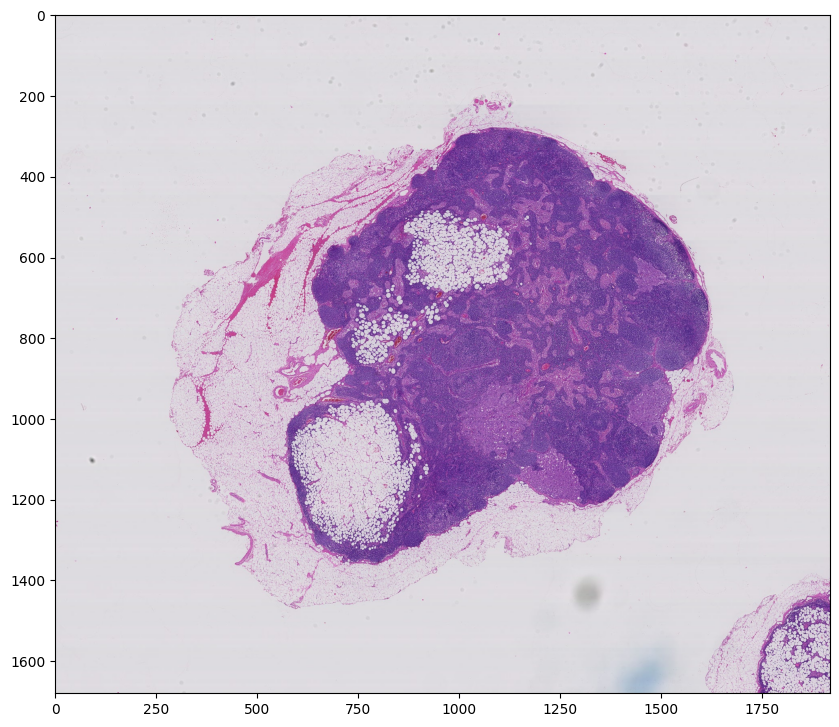

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

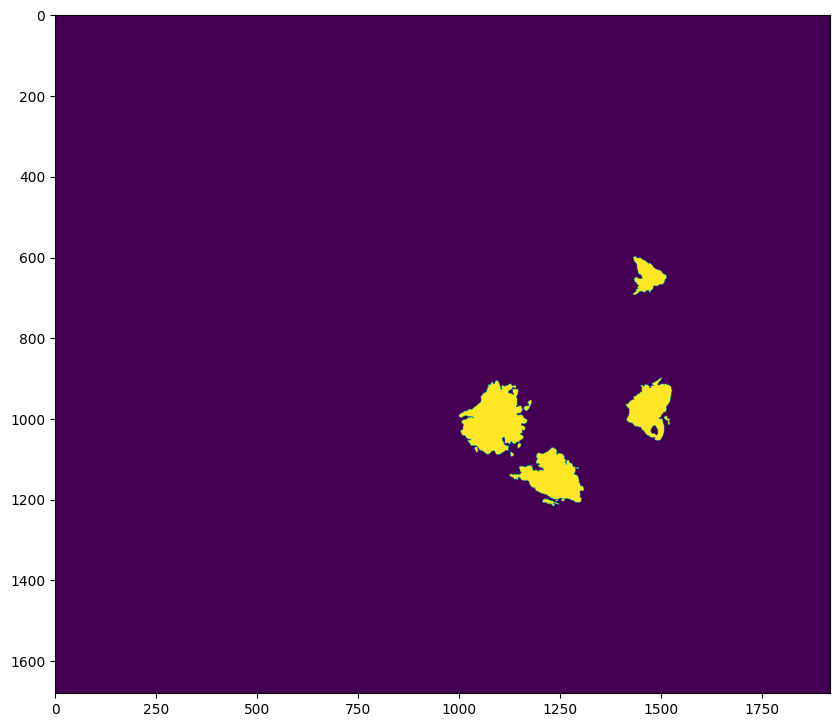

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100) # dpi: integer, optional, default: None; resolution of the figure. 
                                            #If not provided, defaults to 100
plt.imshow(mask_image)

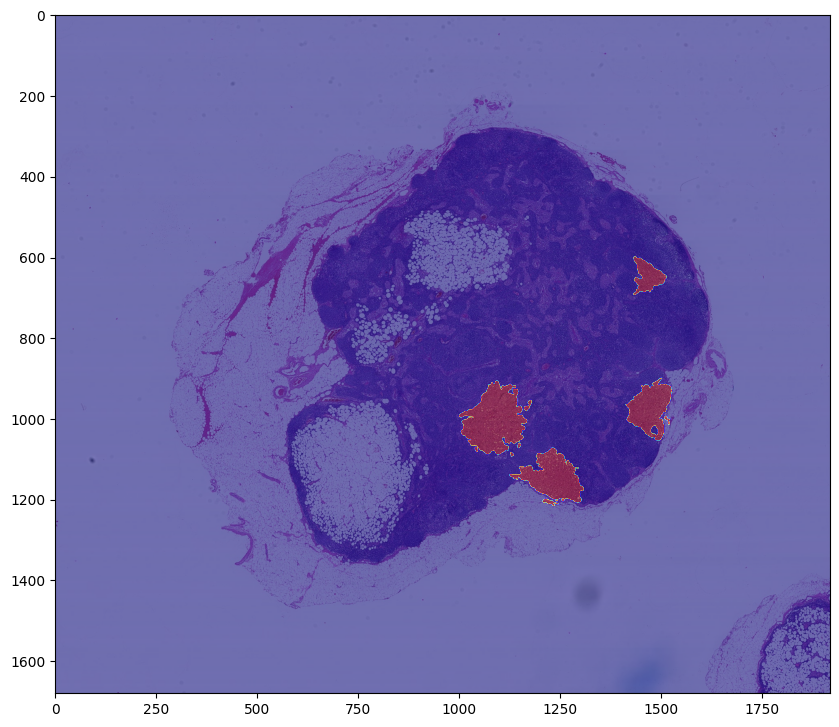

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

----

**save to "run before" here**

---

**Below code is used to extract patches**

# Extract pathces

In [ ]:
def download(slide_path, tumor_mask_path):
  slide_url = 'https://storage.googleapis.com/columbia_applied_dl/%s' % slide_path
  mask_url = 'https://storage.googleapis.com/columbia_applied_dl/%s' % tumor_mask_path

  # Download the whole slide image
  if not os.path.exists(slide_path):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url


In [ ]:
#indices = ['075','091','078']
indices = ['075']

In [ ]:
for slide in indices:
  slide_path = 'tumor_'+ slide +'.tif' 
  tumor_mask_path = 'tumor_'+ slide +'_mask.tif'

  download(slide_path, tumor_mask_path)

  slide = open_slide(slide_path)
  print("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

  tumor_mask = open_slide(tumor_mask_path)
  print("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels" % len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    #assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    #assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
Slide includes 9 levels
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256


In [ ]:
for idx in indices:
  slide_path = 'tumor_'+ idx +'.tif' 
  tumor_mask_path = 'tumor_'+ idx +'_mask.tif'

  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)  

  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=1, 
                         width=slide.level_dimensions[1][0], 
                         height=slide.level_dimensions[1][1])
  
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=1, 
                        width=slide.level_dimensions[1][0], 
                        height=slide.level_dimensions[1][1])[:,:,0]

In [ ]:
# patches with at least one cancerous cell in the mask at LEVEL 5

slide_image_5 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])
  
mask_image_5 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])[:,:,0]

patches_img = patchify(slide_image_5, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap
patches_m_img = patchify(mask_image_5, (299, 299), step=299) 

for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:,:]
    single_mask_img = patches_m_img[i,j,:,:]
    #print(single_patch_img.shape)
    #print(np.sum(single_mask_img))
    if np.sum(single_mask_img) > 0:
      print(i,j)

In [ ]:
# compared to the code block above, added the selection criteria of gray area less than 20%

patches_img = patchify(slide_image_5, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap
patches_m_img = patchify(mask_image_5, (299, 299), step=299) 

threshold = 0

for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:,:]
    single_mask_img = patches_m_img[i,j,:,:]
    tissue_pixels = find_tissue_pixels(single_patch_img)
    percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
    if percent_tissue >= 0.15: # use 0.15 here after experiment, as 0.2 gives too few patches while 0.1 too many
      if np.sum(single_mask_img) > threshold:
        print(i,j)

In [ ]:
# source: https://stackoverflow.com/questions/20368413/draw-grid-lines-over-an-image-in-matplotlib

# A useful visualization to check if patch labels match their ground truths at LEVEL 5

import matplotlib.ticker as plticker

image = Image.fromarray(mask_image_5)
my_dpi=100.

# Set up figure, scale by a factor of d for visualization purpose
d = 3
fig=plt.figure(figsize=(float(image.size[0]/d)/my_dpi,float(image.size[1]/d)/my_dpi),dpi=my_dpi)
ax=fig.add_subplot(111)

# Remove whitespace from around the image
#fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

# Set the gridding interval: here we use the major tick interval
myInterval=299.
loc = plticker.MultipleLocator(base=myInterval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)

# Add the grid
ax.grid(which='major', axis='both', linestyle='-')

# Add the image
ax.imshow(image)

# Find number of gridsquares in x and y direction
nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))

# Add some labels to the gridsquares
for j in range(ny):
    y=myInterval/2+j*myInterval
    for i in range(nx):
        x=myInterval/2.+float(i)*myInterval
        ax.text(x,y,'({:d},{:d})'.format(j,i),color='r',ha='center',va='center')

In [ ]:
# FINAL CODE FOR LEVEL 1

gdrive_root_pos = "/content/gdrive/MyDrive/Colab Notebooks/ADL/Project/level_1/patches/pos/"
gdrive_root_neg = "/content/gdrive/MyDrive/Colab Notebooks/ADL/Project/level_1/patches/neg/"

patches_img = patchify(slide_image, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap
patches_m_img = patchify(mask_image, (299, 299), step=299) 

threshold = 299*299*0.05 # arbitrarily pick x% as the threshold for classifying positive

for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:,:]
    single_mask_img = patches_m_img[i,j,:,:]
    tissue_pixels = find_tissue_pixels(single_patch_img)
    percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
    if percent_tissue >= 0.2: # 0.2 for level 1 and 0.15 for level 2
      if np.sum(single_mask_img) > threshold:
        cv2.imwrite(gdrive_root_pos + idx + '_patch_' +f"{i:03}" + f"{j:03}"+ ".jpg", single_patch_img)
      else:
        cv2.imwrite(gdrive_root_neg+ idx + '_patch_' + f"{i:03}" + f"{j:03}" + ".jpg", single_patch_img)

----
**Below code is to check patches in google drive**

In [ ]:
!pwd

In [ ]:
cd gdrive/MyDrive/"Colab Notebooks"/ADL/Project/level_1/patches/pos

In [ ]:
!ls -1 | wc -l

In [ ]:
cd ..

In [ ]:
cd neg

In [ ]:
!ls -1 | wc -l

In [ ]:
cd ..

----

**Below code is for training**

# Train a model

In [ ]:
batch_size = 32
img_height = 299
img_width = 299

In [ ]:
import pathlib

data_org = './gdrive/MyDrive/Colab Notebooks/ADL/Project/level_1/patches'
data_dir = pathlib.Path(data_org)
print(data_dir)

In [ ]:
!pwd
# it needs to be "content" for the code below to work

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
AUTOTUNE = tf.data.experimental.AUTOTUNE

all_image_paths = list(data_dir.glob('*/*'))

all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# only run this code once
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# transfer learning

from tensorflow.keras.applications.inception_v3 import InceptionV3

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:

base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# must run this line before saving and loading the model
# otherwise, will get an error message saying ax does not match array
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
'''
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Set it to be False
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
'''

In [ ]:
def create_functional_model():
  inputs = tf.keras.Input(shape=(299, 299, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_model.trainable = False # must have this line; otherwise will get an error message when loading the model
  return model

In [ ]:
model = create_functional_model()

In [ ]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00005)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

neg = 15800
pos = 3773
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


In [ ]:
drive_root = '/content/gdrive/My Drive/'
checkpoint_dir = os.path.join(drive_root, "Colab Notebooks/ADL/Project/checkpoints")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:03d}.ckpt")
checkpoint_path

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))


In [ ]:
initial_epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs,
  class_weight=class_weight,
  callbacks=[cp_callback]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# source: https://www.tensorflow.org/guide/keras/save_and_serialize

#functional_model = create_functional_model()
model.save_weights("pretrained_weights_dec13.h5")

In [ ]:
# In a separate program:
pretrained_model = create_functional_model()
#pretrained_model.load_weights("pretrained_weights_dec13.h5")
pretrained_model.load_weights("pretrained_weights_level_1.h5")

# Create a new model by extracting layers from the original model:
extracted_layers = pretrained_model.layers
extracted_layers

In [ ]:
#model = tf.keras.Sequential(pretrained_model)

#source: https://github.com/tensorflow/tensorflow/issues/39391

In [ ]:
pretrained_model.summary()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00005/10)

pretrained_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
pretrained_model.summary()

In [ ]:
len(pretrained_model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = pretrained_model.fit(train_ds,
                         epochs=total_epochs,
                         validation_data=val_ds,
                         class_weight=class_weight,
                         initial_epoch=initial_epochs-1,
                         callbacks=[cp_callback])

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history_fine.epoch

In [ ]:
history_fine.epoch[-1]

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
pretrained_model.save_weights("finetuned_weights_dec14.h5")

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.85, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# extract data/labels back from TensorFlow dataset
points = test_dataset.map(lambda x, y: x)
labels = test_dataset.map(lambda x, y: y)
preds = model.predict(points,batch_size=32)
predictions = tf.nn.sigmoid(preds)
predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
preds.shape

In [ ]:
# source : https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
y = np.concatenate([y for x, y in test_dataset], axis=0)
y.shape

In [ ]:
import seaborn as sns

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

print("***** Test Set Analysis *****")
print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(y, predictions, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(y, predictions)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
plot_cm(y,predictions)

---

**Inference starts here**

# Perform inference

In [ ]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels" % len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [ ]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])[:,:,0]


plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [ ]:
slide_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=1, 
                         width=slide.level_dimensions[1][0], 
                         height=slide.level_dimensions[1][1])

In [ ]:
mask_image_1 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=1, 
                        width=slide.level_dimensions[1][0], 
                        height=slide.level_dimensions[1][1])[:,:,0]

In [ ]:
# create a mask with all zeros that will later be filled with predictions - level 2

patches_img = patchify(slide_image_1, (299, 299, 3), step=299)

single_mask_img = np.zeros((patches_img.shape[0],patches_img.shape[1]))
single_mask_img.shape

In [ ]:
# load the model - step 1.1

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# load the model - step 1.2

def create_functional_model():

  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(1)
  preprocess_input = tf.keras.applications.inception_v3.preprocess_input

  base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')
  
  
  inputs = tf.keras.Input(shape=(299, 299, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_model.trainable = False # must have this line; otherwise will get an error message when loading the model
  return model

In [ ]:
model = create_functional_model()
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00005/10)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def load_model():
  model = create_functional_model()
  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 200

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  opt = keras.optimizers.Adam(learning_rate=0.00005/10)

  model.compile(optimizer=opt,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
# load the model - step 2

# In a separate program:
model = load_model()
model.load_weights("finetuned_weights_dec14.h5")

# Create a new model by extracting layers from the original model:
extracted_layers = model.layers
extracted_layers

In [ ]:
model.summary()

In [ ]:
# get predictions from the model - level 1

patches_img = patchify(slide_image_1, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap

for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:,:]
    tissue_pixels = find_tissue_pixels(single_patch_img)
    percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
    if percent_tissue >= 0.2:
      single_patch_img = np.expand_dims(single_patch_img, axis=0)
      preds = model.predict(single_patch_img, verbose=0)
      predictions = tf.nn.sigmoid(preds)
      pred_label = tf.where(predictions < 0.5, 0, 1)
      single_mask_img[i,j] = pred_label

In [ ]:
# show all indices that belong to the positive class
np.where(single_mask_img == 1)

In [ ]:
l = 1
print("Level %d, dimensions: %s downsample factor %d" % (l, slide.level_dimensions[l], slide.level_downsamples[l]))

In [ ]:
slide.level_dimensions[l][0]

In [ ]:
# initiate prediction array to be all zeros
pred_1 = np.zeros((slide.level_dimensions[l][1], slide.level_dimensions[l][0]))
pred_1.shape

In [ ]:
# can be inside the pred array
mask_image_1.shape

In [ ]:
# get the index pairs / (x,y) coordinates that belong to the positive class

indices = np.where(single_mask_img == 1)
idx_pair = list(zip(indices[0], indices[1]))

In [ ]:
# create a block of 1s, same size as each patch: (299,299)
block = np.ones((299,299))
block.shape

In [ ]:
# loop over all pairs of positive indices at level 1
for idx in idx_pair:
  x = idx[0] * 299
  y = idx[1] * 299
  pred_1[x:x+block.shape[0], y:y+block.shape[1]] = block

# source: https://stackoverflow.com/questions/7115437/how-to-embed-a-small-numpy-array-into-a-predefined-block-of-a-large-numpy-arra

In [ ]:
# old for level 1
# heatmap of level_1 slide predictions (no downsizing here, takes a lot of RAM)

plt.imshow(pred_1, cmap='binary')

In [ ]:
# https://stackoverflow.com/questions/4624112/grouping-2d-numpy-array-in-average

# Downside a heatmap from level 2 to level 5 for visualization
height, width = pred_1.shape
N = 16 # from level 1 to 5
heatmap = np.average(np.split(np.average(np.split(pred_1, width // N, axis=1), axis=-1), height // N, axis=1), axis=-1)
heatmap.shape

In [ ]:
# using finetuned_weights_dec14.h5

# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# using finetuned_weights_dec14.h5

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
# baseline using pretrained_model.h5

# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten().astype(np.uint8)
heatmap_cm.shape

In [ ]:
mask_image_cm = mask_image.flatten()
mask_image_cm.shape

In [ ]:
# using finetuned_weights_dec14.h5

print("***** Test Data Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

cf = confusion_matrix(mask_image_cm, heatmap_cm)

print("-"*30)
print('True Negatives: ', cf[0][0])
print('False Positives: ', cf[0][1])
print('False Negatives: ', cf[1][0])
print('True Positives: ', cf[1][1])
print('Total: ', np.sum(cf[1]))
print()

sns.heatmap(cf, annot = True, fmt = 'd')
plt.title("Confusion Matrix for Test Set")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# baseline using pretrained_model.h5

print("***** Test Data Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

cf = confusion_matrix(mask_image_cm, heatmap_cm)

print("-"*30)
print('True Negatives: ', cf[0][0])
print('False Positives: ', cf[0][1])
print('False Negatives: ', cf[1][0])
print('True Positives: ', cf[1][1])
print('Total: ', np.sum(cf[1]))
print()

sns.heatmap(cf, annot = True, fmt = 'd')
plt.title("Confusion Matrix for Test Set")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# using pretrained_weights_dec13.h5

print("***** Test Set Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
# using pretrained_weights_dec13.h5

# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# using pretrained_weights_dec13.h5

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten().astype(np.uint8)
heatmap_cm.shape

In [ ]:
mask_image_cm = mask_image.flatten()
mask_image_cm.shape

In [ ]:
# old image trained on one slide
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# old image trained on one slide
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten()

In [ ]:
heatmap_cm.shape

In [ ]:
mask_image_cm = mask_image.flatten()
mask_image_cm.shape

In [ ]:
heatmap_cm.dtype

In [ ]:
heatmap_cm = heatmap_cm.astype(np.uint8)

In [ ]:
heatmap_cm.dtype

In [ ]:
mask_image_cm.dtype

In [ ]:
# old image trained on one slide
plot_cm(mask_image_cm,heatmap_cm)

In [ ]:
# old image trained on one slide
print("***** Test Set Analysis *****")
print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
# import a new slide

# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_075.tif' # only this file is available
tumor_mask_path = 'tumor_075_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/columbia_applied_dl/tumor_075.tif'
mask_url = 'https://storage.googleapis.com/columbia_applied_dl/tumor_075_mask.tif'

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url


In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels" % len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [ ]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100) # dpi: integer, optional, default: None; resolution of the figure. 
                                            #If not provided, defaults to 100
plt.imshow(mask_image)

In [ ]:
slide_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=1, 
                         width=slide.level_dimensions[1][0], 
                         height=slide.level_dimensions[1][1])

In [ ]:
mask_image_1 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=1, 
                        width=slide.level_dimensions[1][0], 
                        height=slide.level_dimensions[1][1])[:,:,0]

In [ ]:
# create a mask with all zeros that will later be filled with predictions

patches_img = patchify(slide_image_1, (299, 299, 3), step=299)

single_mask_img = np.zeros((patches_img.shape[0],patches_img.shape[1]))
single_mask_img.shape

In [ ]:
# load the model - step 1.1

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# load the model - step 1.2

def create_functional_model():
  inputs = tf.keras.Input(shape=(299, 299, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_model.trainable = False # must have this line; otherwise will get an error message when loading the model
  return model

In [ ]:
# load the model - step 2

# In a separate program:
model = create_functional_model()
model.load_weights("pretrained_weights_level_1.h5")

# Create a new model by extracting layers from the original model:
extracted_layers = model.layers
extracted_layers

In [ ]:
# load the model - step 3

from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00005)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# get predictions from the model

patches_img = patchify(slide_image_1, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap

for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:,:]
    tissue_pixels = find_tissue_pixels(single_patch_img)
    percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
    if percent_tissue >= 0.2:
      single_patch_img = np.expand_dims(single_patch_img, axis=0)
      preds = model.predict(single_patch_img, verbose=0)
      predictions = tf.nn.sigmoid(preds)
      pred_label = tf.where(predictions < 0.5, 0, 1)
      single_mask_img[i,j] = pred_label

In [ ]:
# get the index pairs / (x,y) coordinates that belong to the positive class

indices = np.where(single_mask_img == 1)
idx_pair = list(zip(indices[0], indices[1]))

In [ ]:
indices

In [ ]:
# create a block of 1s, same size as each patch: (299,299)
block = np.ones((299,299))
block.shape

In [ ]:
# initiate prediction array to be all zeros
l = 1
pred_1 = np.zeros((slide.level_dimensions[l][1], slide.level_dimensions[l][0]))
pred_1.shape

In [ ]:
mask_image_1.shape

In [ ]:
# loop over all pairs of positive indices at level 2
for idx in idx_pair:
  x = idx[0] * 299
  y = idx[1] * 299
  pred_1[x:x+block.shape[0], y:y+block.shape[1]] = block

In [ ]:
# Downside a heatmap from level 1 to level 5 for visualization
height, width = pred_1.shape
N = 16 # from level 1 to 5
heatmap = np.average(np.split(np.average(np.split(pred_1, width // N, axis=1), axis=-1), height // N, axis=1), axis=-1)
heatmap.shape

In [ ]:
# using finetuned_weights_dec14.h5

# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# using finetuned_weights_dec14.h5

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
# use finetuned_weights_dec14.h5

print("***** Test Data Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

cf = confusion_matrix(mask_image_cm, heatmap_cm)

print("-"*30)
print('True Negatives: ', cf[0][0])
print('False Positives: ', cf[0][1])
print('False Negatives: ', cf[1][0])
print('True Positives: ', cf[1][1])
print('Total: ', np.sum(cf[1]))
print()

sns.heatmap(cf, annot = True, fmt = 'd')
plt.title("Confusion Matrix for Test Set")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# using pretrained_model_level_1.h5

# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten().astype(np.uint8)

In [ ]:
mask_image_cm = mask_image.flatten()
mask_image_cm.shape

In [ ]:
print("***** Test Data Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

cf = confusion_matrix(mask_image_cm, heatmap_cm)

print("-"*30)
print('True Negatives: ', cf[0][0])
print('False Positives: ', cf[0][1])
print('False Negatives: ', cf[1][0])
print('True Positives: ', cf[1][1])
print('Total: ', np.sum(cf[1]))
print()

sns.heatmap(cf, annot = True, fmt = 'd')
plt.title("Confusion Matrix for Test Set")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print("***** Test Set Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
# old using level 1
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# old using level 1
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten().astype(np.uint8)

In [ ]:
mask_image_cm = mask_image.flatten()
mask_image_cm.shape

In [ ]:
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

In [ ]:
# old using level 1
plot_cm(mask_image_cm,heatmap_cm)

In [ ]:
# old using level 1
print("***** Test Set Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
plot_cm(mask_image_cm,heatmap_cm)

In [ ]:
print("***** Test Set Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
# old image trained on one slide
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
# old image trained on one slide
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
slide_path = 'tumor_110.tif' # only this file is available
tumor_mask_path = 'tumor_110_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/columbia_applied_dl/tumor_110.tif'
mask_url = 'https://storage.googleapis.com/columbia_applied_dl/tumor_110_mask.tif'

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels" % len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [ ]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100) # dpi: integer, optional, default: None; resolution of the figure. 
                                            #If not provided, defaults to 100
plt.imshow(mask_image)

In [ ]:
slide_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=1, 
                         width=slide.level_dimensions[1][0], 
                         height=slide.level_dimensions[1][1])

In [ ]:
mask_image_1 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=1, 
                        width=slide.level_dimensions[1][0], 
                        height=slide.level_dimensions[1][1])[:,:,0]

In [ ]:
# create a mask with all zeros that will later be filled with predictions

patches_img = patchify(slide_image_1, (299, 299, 3), step=299)

single_mask_img = np.zeros((patches_img.shape[0],patches_img.shape[1]))
single_mask_img.shape

In [ ]:
# get predictions from the model

patches_img = patchify(slide_image_1, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap

for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,0,:,:,:]
    tissue_pixels = find_tissue_pixels(single_patch_img)
    percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
    if percent_tissue >= 0.2:
      single_patch_img = np.expand_dims(single_patch_img, axis=0)
      preds = model.predict(single_patch_img, verbose=0)
      predictions = tf.nn.sigmoid(preds)
      pred_label = tf.where(predictions < 0.5, 0, 1)
      single_mask_img[i,j] = pred_label

In [ ]:
# get the index pairs / (x,y) coordinates that belong to the positive class

indices = np.where(single_mask_img == 1)
idx_pair = list(zip(indices[0], indices[1]))

In [ ]:
indices

In [ ]:
# create a block of 1s, same size as each patch: (299,299)
block = np.ones((299,299))
block.shape

In [ ]:
mask_image_1.shape

In [ ]:
#pred_1 = np.zeros((35840, 47104))

In [ ]:
# initiate prediction array to be all zeros
l = 1
pred_1 = np.zeros((slide.level_dimensions[l][1], slide.level_dimensions[l][0]))
pred_1.shape

In [ ]:
# loop over all pairs of positive indices at level 2
for idx in idx_pair:
  x = idx[0] * 299
  y = idx[1] * 299
  pred_1[x:x+block.shape[0], y:y+block.shape[1]] = block

In [ ]:
# Downside a heatmap from level 1 to level 5 for visualization
height, width = pred_1.shape
N = 16 # from level 1 to 5
heatmap = np.average(np.split(np.average(np.split(pred_1, width // N, axis=1), axis=-1), height // N, axis=1), axis=-1)
heatmap.shape

In [ ]:
# use finetuned_weights_dec14.h5
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# use finetuned_weights_dec14.h5
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
# use finetuned_weights_dec14.h5

print("***** Test Data Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])

cf = confusion_matrix(mask_image_cm, heatmap_cm)

print("-"*30)
print('True Negatives: ', cf[0][0])
print('False Positives: ', cf[0][1])
print('False Negatives: ', cf[1][0])
print('True Positives: ', cf[1][1])
print('Total: ', np.sum(cf[1]))
print()

sns.heatmap(cf, annot = True, fmt = 'd')
plt.title("Confusion Matrix for Test Set")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# pretrained model - level 2
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# pretrained model - level 2
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten().astype(np.uint8)
mask_image_cm = mask_image.flatten()

In [ ]:
# pretrained model - level 2
plot_cm(mask_image_cm,heatmap_cm)

In [ ]:
# pretrained model - level 2
print("***** Test Set Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
# old using level 1
# heatmap of level 5 predictions
plt.imshow(heatmap, cmap='binary')

In [ ]:
# old using level 1
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
heatmap_cm = heatmap.flatten().astype(np.uint8)

In [ ]:
mask_image_cm = mask_image.flatten()
mask_image_cm.shape

In [ ]:
# old using level 1
plot_cm(mask_image_cm,heatmap_cm)

In [ ]:
# old using level 1
print("***** Test Set Analysis *****")
#print("Accuracy on Test Set : {:0.4f}".format(accuracy))
prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
print("Precision : ", prfs[0])
print("Recall : ", prfs[1])
print("F1 Score : ", prfs[2])
cf = confusion_matrix(mask_image_cm, heatmap_cm)
sns.heatmap(cf, annot = True, fmt = 'g')
plt.title("Confusion Matrix for Test Set")
plt.show()

---
functions

In [ ]:
def download(slide_path, tumor_mask_path):
  slide_url = 'https://storage.googleapis.com/columbia_applied_dl/%s' % slide_path
  mask_url = 'https://storage.googleapis.com/columbia_applied_dl/%s' % tumor_mask_path

  # Download the whole slide image
  if not os.path.exists(slide_path):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url


In [ ]:
def describe_slide(slide_path, tumor_mask_path):
  slide = open_slide(slide_path)
  print("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

  tumor_mask = open_slide(tumor_mask_path)
  print("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels" % len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]
  print()
  
  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [ ]:
def plot_slide(idx, level):

  #slide_path = 'tumor_'+ idx +'.tif' 

  slide = slides[idx]

  #slide = open_slide(slide_path)

  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  return slide_image

In [ ]:
def plot_mask(idx, level):

  #tumor_mask_path = 'tumor_'+ idx +'_mask.tif'

  tumor_mask = masks[idx]

  #tumor_mask = open_slide(tumor_mask_path)  

  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0], 
                        height=tumor_mask.level_dimensions[level][1])[:,:,0]

  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(mask_image)
  return mask_image

In [ ]:
def plot_overlay(slide, mask):
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide)
  plt.imshow(mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
def load_model():

  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(1)
  preprocess_input = tf.keras.applications.inception_v3.preprocess_input

  base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')
  
  
  inputs = tf.keras.Input(shape=(299, 299, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #base_model.trainable = False

  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 200

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  opt = keras.optimizers.Adam(learning_rate=0.00005/10)

  model.compile(optimizer=opt,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
def load_slide(idx, level):

  slide = slides[idx]  
  slide_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

  return slide_image_1

In [ ]:
def load_mask(idx, level):

  tumor_mask = masks[idx]
  mask_image_1 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

                        # create a mask with all zeros that will later be filled with predictions - level 2

  return mask_image_1

In [36]:
def predict(model, slide_image_1, level):

  patches_img = patchify(slide_image_1, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap

  single_mask_img = np.zeros((patches_img.shape[0],patches_img.shape[1]))

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,0,:,:,:]
      tissue_pixels = find_tissue_pixels(single_patch_img)
      percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
      if percent_tissue >= 0.2:
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        preds = model.predict(single_patch_img, verbose=0)
        predictions = tf.nn.sigmoid(preds)
        pred_label = tf.where(predictions < 0.5, 0, 1)
        single_mask_img[i,j] = pred_label
    
  
  # get the index pairs / (x,y) coordinates that belong to the positive class

  indices = np.where(single_mask_img == 1)
  idx_pair = list(zip(indices[0], indices[1]))

  # create a block of 1s, same size as each patch: (299,299)
  block = np.ones((299,299))
  
  # initiate prediction array to be all zeros
  pred_1 = np.zeros((slide_image_1.shape[0], slide_image_1.shape[1]))

  # loop over all pairs of positive indices at level 2
  for idx in idx_pair:
    x = idx[0] * 299
    y = idx[1] * 299
    pred_1[x:x+block.shape[0], y:y+block.shape[1]] = block

  return pred_1

In [ ]:
def downsize(pred_1, level):
  # Downside a heatmap from level 1 to level 5 for visualization
  height, width = pred_1.shape

  d = 5 - level # difference between the current level and level 5
  N = pow(2,d) # from level 1 to 5, N = 16

  heatmap = np.average(np.split(np.average(np.split(pred_1, width // N, axis=1), axis=-1), height // N, axis=1), axis=-1)

  return heatmap

In [ ]:
slide_image_1 = load_slide(idx=1, level=1)

In [35]:
slide_image_1.shape

(26880, 30720, 3)

In [37]:
pred_1 = predict(model=model, slide_image_1=slide_image_1, level=1)

In [39]:
heatmap = downsize(pred_1, level=1)

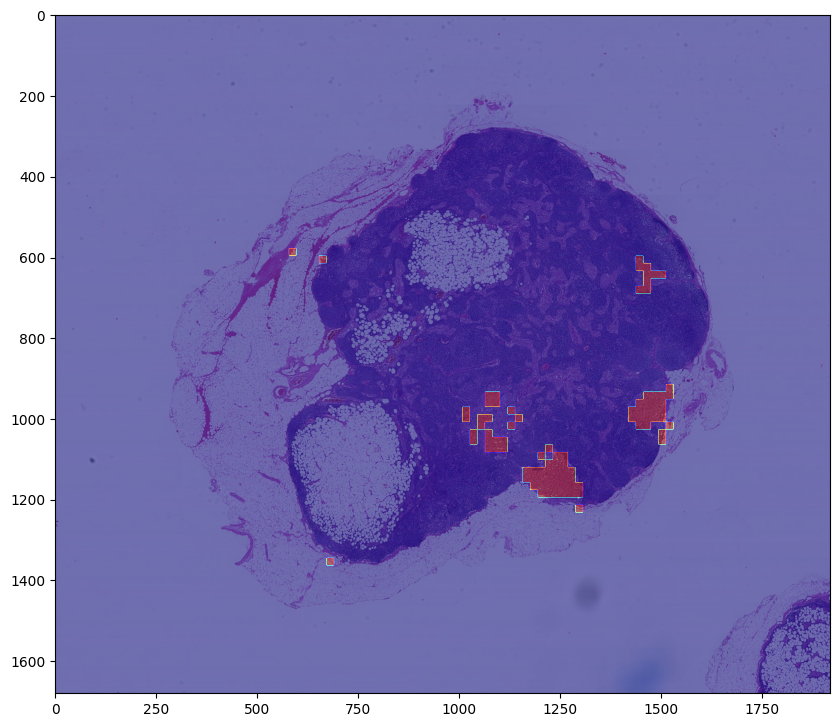

In [42]:
plot_overlay(slide_image, heatmap)

***** Test Data Analysis *****
Precision :  0.9210637400788375
Recall :  0.778858560526559
F1 Score :  0.8350853788427366
------------------------------
True Negatives:  3174183
False Positives:  4665
False Negatives:  20609
True Positives:  26143
Total:  46752



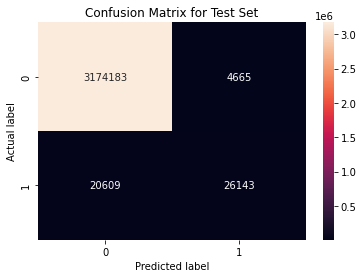

In [41]:
create_cm(heatmap, mask_image)

In [43]:
def create_heatmap(idx, level, model):

  slide_image_1 = load_slide(idx, level)

  pred_1 = predict(model=model, slide_image_1=slide_image_1, level=level)

  heatmap = downsize(pred_1, level)

  return heatmap

In [ ]:
def create_cm(heatmap, mask_image):
  heatmap_cm = heatmap.flatten().astype(np.uint8)
  mask_image_cm = mask_image.flatten()

  print("***** Test Data Analysis *****")
  #print("Accuracy on Test Set : {:0.4f}".format(accuracy))
  prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
  print("Precision : ", prfs[0])
  print("Recall : ", prfs[1])
  print("F1 Score : ", prfs[2])

  cf = confusion_matrix(mask_image_cm, heatmap_cm)

  print("-"*30)
  print('True Negatives: ', cf[0][0])
  print('False Positives: ', cf[0][1])
  print('False Negatives: ', cf[1][0])
  print('True Positives: ', cf[1][1])
  print('Total: ', np.sum(cf[1]))
  print()

  sns.heatmap(cf, annot = True, fmt = 'd')
  plt.title("Confusion Matrix for Test Set")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
indices = ['075','091','078']

In [ ]:
slides = []
masks = []

for slide in indices:

  slide_path = 'tumor_'+ slide +'.tif' 
  tumor_mask_path = 'tumor_'+ slide +'_mask.tif'

  download(slide_path, tumor_mask_path)
  print()

  describe_slide(slide_path, tumor_mask_path)

  slides.append(open_slide(slide_path))
  masks.append(open_slide(tumor_mask_path))


Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
Slide includes 9 levels
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256


Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3

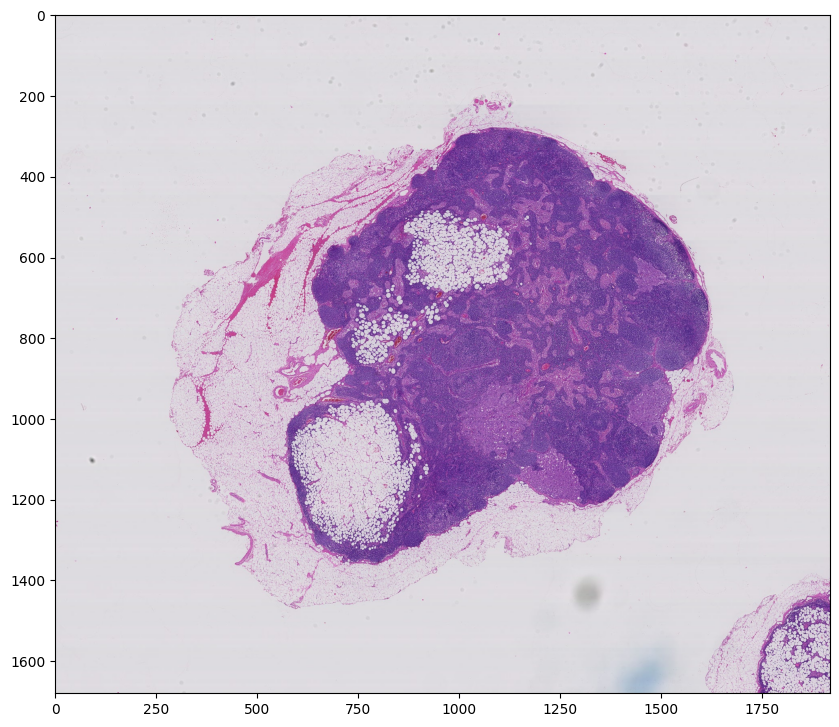

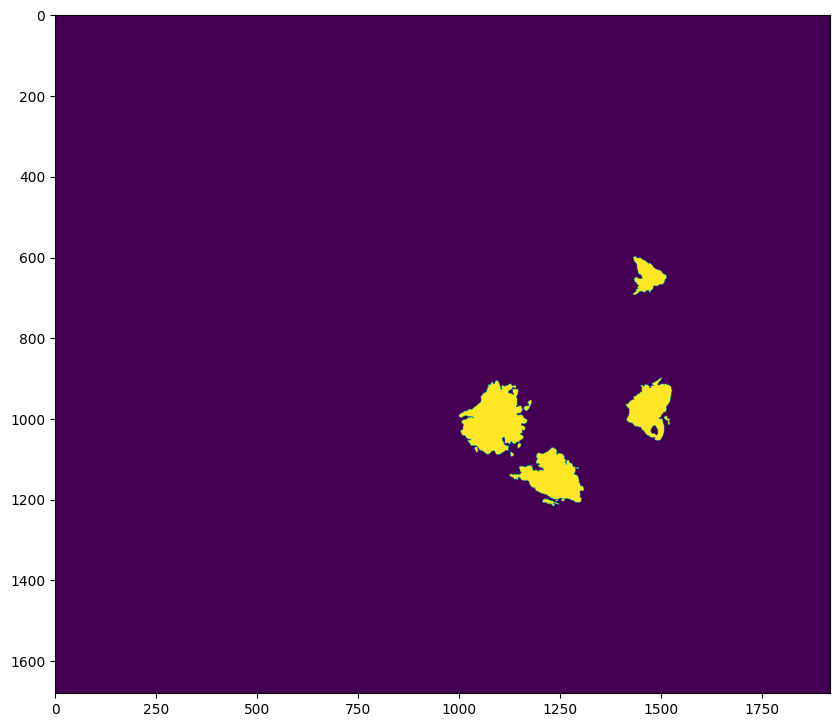

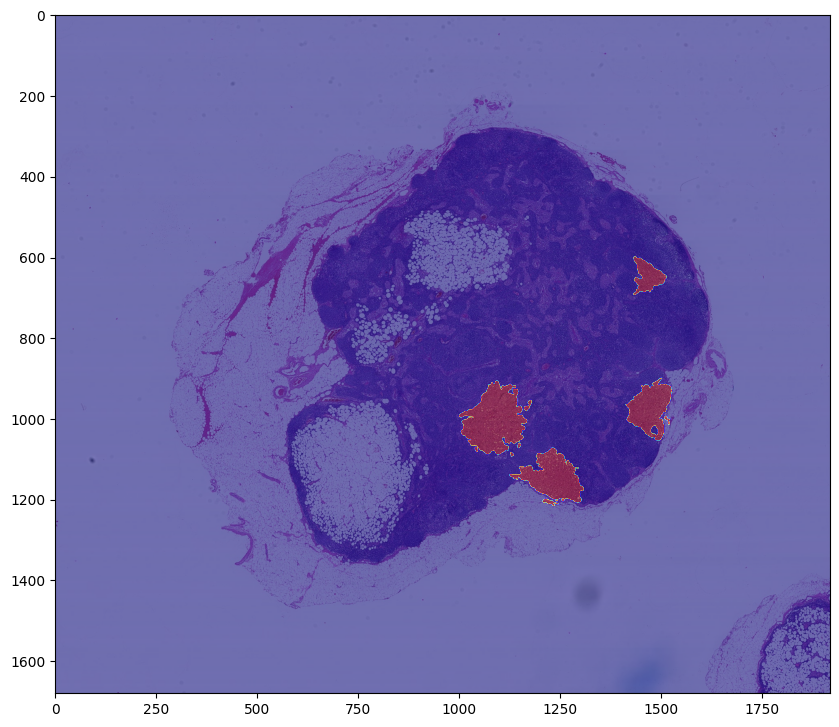

In [ ]:
slide_image  = plot_slide(1, 5)
mask_image = plot_mask(1,5)
plot_overlay(slide_image, mask_image)

In [ ]:
model = load_model()
model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                              

In [ ]:
model.load_weights("finetuned_weights_dec14.h5")

In [ ]:
heatmap = create_heatmap(idx=1, level=1, model=model)

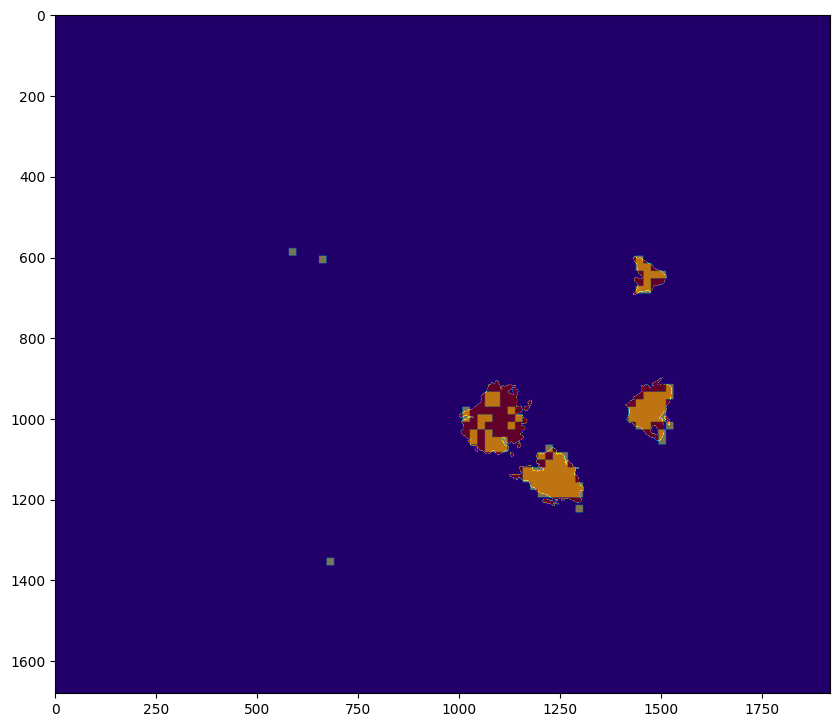

In [48]:
plot_overlay(heatmap,mask_image)

***** Test Data Analysis *****
Precision :  0.9210637400788375
Recall :  0.778858560526559
F1 Score :  0.8350853788427366
------------------------------
True Negatives:  3174183
False Positives:  4665
False Negatives:  20609
True Positives:  26143
Total:  46752



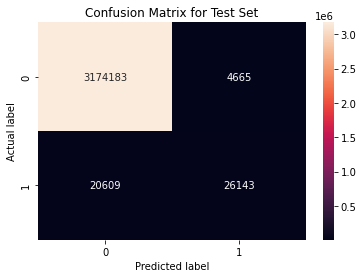

In [45]:
create_cm(heatmap, mask_image)